In [1]:
%run ../../src/start.py


python	3.9.6 (default, Jul 30 2021, 16:35:19) 
[GCC 7.5.0]
---------------------
Versions:
----------------------
pandas      1.3.1
numpy       1.20.3
matplotlib  3.4.2
seaborn     0.11.1
plotly      5.1.0
boto3       1.18.16
awswrangler 2.10.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
# Creating the low level functional client
client = boto3.client(
    's3',
    aws_access_key_id = AWS_KEY_ID,
    aws_secret_access_key = AWS_SECRET,
)
    
# Creating the high level object oriented interface
resource = boto3.resource(
    's3',
    aws_access_key_id = AWS_KEY_I

## Load Data

In [2]:
# year file
year = '2009'

In [3]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [8]:
raw = bucket_raw_path('dend-data',f'capstone/raw-data/crime-data/{year}')
raw

's3://dend-data/capstone/raw-data/crime-data/2009'

## List objects in bucket

In [9]:
wr.s3.list_objects(raw)

['s3://dend-data/capstone/raw-data/crime-data/2009/aug09.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2009/dec09.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2009/jul09.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2009/nov09.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2009/oct09.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2009/sep09.xlsx']

## Create dataframe from s3 files

In [10]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_excel(i, engine='openpyxl')
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [11]:
%%time
df = s3_files_to_df(raw)

CPU times: user 13.8 s, sys: 39.8 ms, total: 13.9 s
Wall time: 20.7 s


In [12]:
## cleanup columns
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73019 entries, 0 to 73018
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           73019 non-null  datetime64[ns]
 1   hour           73019 non-null  int64         
 2   offense_type   73019 non-null  object        
 3   beat           73019 non-null  object        
 4   premise        73019 non-null  object        
 5   block_range    73019 non-null  object        
 6   street_name    73019 non-null  object        
 7   type           73019 non-null  object        
 8   suffix         73019 non-null  object        
 9   #_of_offenses  23873 non-null  float64       
 10  ._of_offenses  49146 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 6.1+ MB


In [14]:
df.head()

,date,hour,offense_type,beat,premise,block_range,street_name,type,suffix,#_of_offenses,._of_offenses
0,2009-08-01,0,Robbery,3B30,210,3000-3099,DURHAM,DR,N,1.0,NaN
1,2009-08-01,0,Robbery,6B60,20A,500-599,SEMINAR,DR,-,1.0,NaN
2,2009-08-01,0,Robbery,6B30,18N,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,1.0,NaN
3,2009-08-01,0,Robbery,18F30,18A,6300-6399,SKYLINE,DR,-,1.0,NaN
4,2009-08-01,0,Robbery,2A20,18N,5900-5999,FULTON,ST,-,1.0,NaN


## Show null data

In [15]:
df.apply(lambda x: sum(x.isnull()))

date                 0
hour                 0
offense_type         0
beat                 0
premise              0
block_range          0
street_name          0
type                 0
suffix               0
#_of_offenses    49146
._of_offenses    23873
dtype: int64

In [16]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
#_of_offenses,67.31
._of_offenses,32.69
date,0.00
hour,0.00
offense_type,0.00
beat,0.00
premise,0.00
block_range,0.00
street_name,0.00
type,0.00


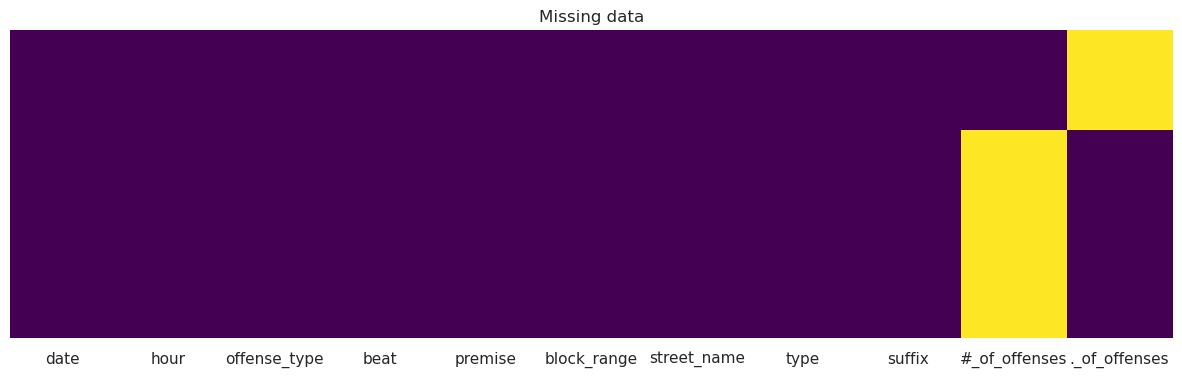

In [17]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Combine and drop columns

In [18]:
# combine columns into a new one
df['offenses'] = pd.concat([df['#_of_offenses'].dropna(),
                              df['._of_offenses'].dropna()]).reindex_like(df)

# drop columns
df = df.drop(['#_of_offenses','._of_offenses'], axis = 1)

In [19]:
df.apply(lambda x: sum(x.isnull()))

date            0
hour            0
offense_type    0
beat            0
premise         0
block_range     0
street_name     0
type            0
suffix          0
offenses        0
dtype: int64

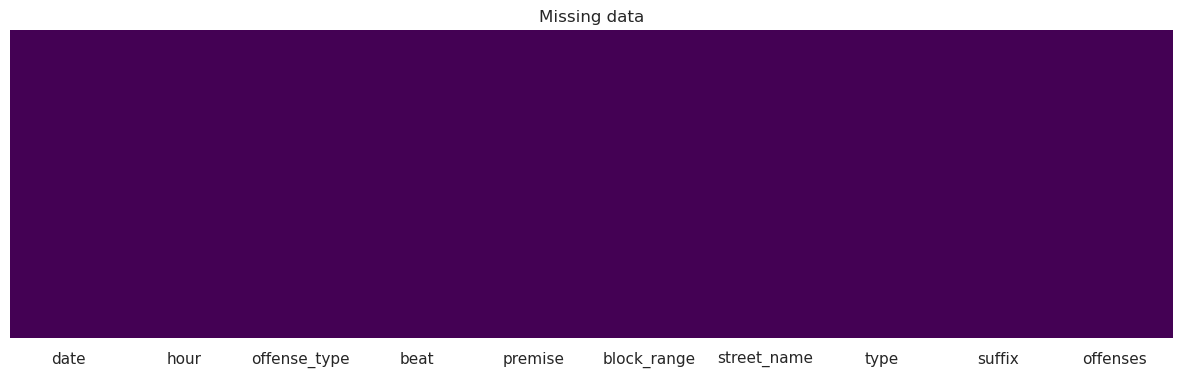

In [20]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Combine columns 

## Combine date & hour to one column

In [21]:
# convert two columns into one datetime
df['date_time'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# drop columns
df = df.drop(['date','hour'], axis = 1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73019 entries, 0 to 73018
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   offense_type  73019 non-null  object        
 1   beat          73019 non-null  object        
 2   premise       73019 non-null  object        
 3   block_range   73019 non-null  object        
 4   street_name   73019 non-null  object        
 5   type          73019 non-null  object        
 6   suffix        73019 non-null  object        
 7   offenses      73019 non-null  float64       
 8   date_time     73019 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 5.0+ MB


In [23]:
df.head()

,offense_type,beat,premise,block_range,street_name,type,suffix,offenses,date_time
0,Robbery,3B30,210,3000-3099,DURHAM,DR,N,1.0,2009-08-01
1,Robbery,6B60,20A,500-599,SEMINAR,DR,-,1.0,2009-08-01
2,Robbery,6B30,18N,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,1.0,2009-08-01
3,Robbery,18F30,18A,6300-6399,SKYLINE,DR,-,1.0,2009-08-01
4,Robbery,2A20,18N,5900-5999,FULTON,ST,-,1.0,2009-08-01


## Convert offenses to integer

In [24]:
# convert offenses to int
df['offenses'] = df['offenses'].astype('int64')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73019 entries, 0 to 73018
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   offense_type  73019 non-null  object        
 1   beat          73019 non-null  object        
 2   premise       73019 non-null  object        
 3   block_range   73019 non-null  object        
 4   street_name   73019 non-null  object        
 5   type          73019 non-null  object        
 6   suffix        73019 non-null  object        
 7   offenses      73019 non-null  int64         
 8   date_time     73019 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 5.0+ MB


# Create a year column
- to identify orgin of data

In [36]:
df['year'] = 2009

In [37]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year
0,2009-08-01,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,2009
1,2009-08-01,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A,2009
2,2009-08-01,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N,2009
3,2009-08-01,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A,2009
4,2009-08-01,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N,2009


## change order of columns

In [38]:
col_ord =['date_time','offenses','offense_type', 'block_range', 'street_name', 'type', 'suffix','beat', 'premise','year']
df = df[col_ord]
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year
0,2009-08-01,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,2009
1,2009-08-01,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A,2009
2,2009-08-01,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N,2009
3,2009-08-01,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A,2009
4,2009-08-01,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N,2009


## Save to bucket

In [39]:
bucket = 'dend-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/inter-data/crime-data/{file_name}"
path_to_save

's3://dend-data/capstone/inter-data/crime-data/crime_2009.csv'

In [40]:
%%time
wr.s3.to_csv(df, path_to_save, index=False)

CPU times: user 298 ms, sys: 10.4 ms, total: 308 ms
Wall time: 7.98 s


{'paths': ['s3://dend-data/capstone/inter-data/crime-data/crime_2009.csv'],
 'partitions_values': {}}

# Save Sample
- for testing
- not to load all data
- duh

In [47]:
sample_100 = df.sample(100)
sample_100.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year
62176,2009-09-16 07:00:00,2,Aggravated Assault,6300-6399,AIRPORT,BLVD,W,17E40,20A,2009
4669,2009-08-12 20:00:00,1,Auto Theft,3100-3199,CRESTDALE,DR,-,4F20,18A,2009
39461,2009-11-08 20:00:00,1,Burglary,400-499,LINK,RD,-,2A20,240,2009
12408,2009-12-01 14:00:00,1,Theft,15300-15399,PARK ROW,-,-,4F30,20A,2009
29021,2009-07-11 00:00:00,1,Auto Theft,5800-5899,HOLLISTER,-,-,5F30,18A,2009


# Save sample

In [48]:
bucket = 'dend-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/sample-data/crime-data/{file_name}"
path_to_save

's3://dend-data/capstone/sample-data/crime-data/crime_2009.csv'

In [49]:
%%time
wr.s3.to_csv(sample_100, path_to_save, index=False)

CPU times: user 18.8 ms, sys: 122 µs, total: 19 ms
Wall time: 383 ms


{'paths': ['s3://dend-data/capstone/sample-data/crime-data/crime_2009.csv'],
 'partitions_values': {}}